# Apply machine learning models to CTD data
Created by Ivan Lima on Tue Nov  2 2021 10:47:31 -0400

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime, warnings
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Tue Nov  9 09:49:26 2021


In [2]:
sns.set_theme(context='paper', style='ticks', palette='tab10', rc={'figure.dpi':100, 'figure.figsize':[5, 5], 'axes.grid':True})
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')

In [3]:
# turn off GridSearchCV annoying warnings when n_jobs=-1
import sys, warnings
warnings.filterwarnings('ignore')
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

## Read bottle & satellite data 

In [4]:
df_bottle = pd.read_csv('data/bottle_satellite_data_clean.csv', parse_dates=['Date'], index_col=0)
df_bottle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2601 entries, 0 to 3039
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   X.x                  2601 non-null   int64         
 1   X.y                  2601 non-null   int64         
 2   DOI                  2601 non-null   object        
 3   EXPOCODE             1466 non-null   object        
 4   Accession            101 non-null    float64       
 5   Cruise_ID            2022 non-null   object        
 6   Date                 2601 non-null   datetime64[ns]
 7   Year                 2601 non-null   int64         
 8   Month                2601 non-null   int64         
 9   Day                  2601 non-null   int64         
 10  Time_UTC             2521 non-null   object        
 11  Latitude             2601 non-null   float64       
 12  Longitude            2601 non-null   float64       
 13  Depth_bottom         1341 non-nul

## Select input features and split data into training and test sets 

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# Set input and output variables
features = ['Depth', 'bottom_depth', 'Temperature', 'Salinity', 'Oxygen', 'pCO2_monthave', 'SLA', 'SST_hires', 'KD490']
targets  = ['DIC', 'TA']

X = df_bottle[features].values
Y = df_bottle[targets].values

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

## Tune & train neural network regression model 

Linear models and neural networks are very tied to the scale and distribution of each feature. Therefore, we rescale input features so they have mean=0 and std=1.

Best cross-validation score: 0.9670
Best parameters: {'mlpregressor__activation': 'logistic', 'mlpregressor__alpha': 0.01, 'mlpregressor__hidden_layer_sizes': [200]}
Best estimator: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='logistic', alpha=0.01,
                              hidden_layer_sizes=[200], random_state=42,
                              solver='lbfgs'))])
Training set score: 0.9739
Test set score:     0.9642
Final model cross-validation mean score: 0.9519


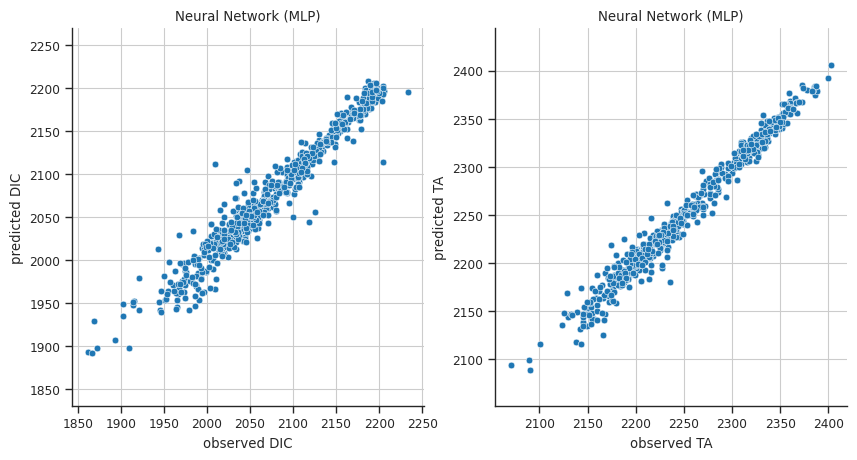

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline, make_pipeline

pipe = make_pipeline(StandardScaler(), MLPRegressor(solver='lbfgs', random_state=42))

param_grid = {'mlpregressor__hidden_layer_sizes': [[100,], [200,], [300,], [400,]],
              'mlpregressor__activation' : ['logistic', 'tanh', 'relu'],
              'mlpregressor__alpha': [0.0001, 0.001, 0.01]}
gs_nnr = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
gs_nnr.fit(X_train, Y_train);

print('Best cross-validation score: {:.4f}'.format(gs_nnr.best_score_))
print('Best parameters: {}'.format(gs_nnr.best_params_))
print('Best estimator: {}'.format(gs_nnr.best_estimator_))

print('Training set score: {:.4f}'.format(gs_nnr.score(X_train, Y_train)))
print('Test set score:     {:.4f}'.format(gs_nnr.score(X_test, Y_test)))

scores = cross_val_score(gs_nnr.best_estimator_, X, Y, cv=5, n_jobs=-1)
print('Final model cross-validation mean score: {:.4f}'.format(scores.mean()))

Y_pred = gs_nnr.predict(X_test)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
_ = sns.scatterplot(x=Y_test[:,0], y=Y_pred[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_test[:,1], y=Y_pred[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Neural Network (MLP)')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Neural Network (MLP)')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

## Read merged CTD & satellite data 

In [7]:
df_ctd = pd.read_hdf('data/ctd_satellite_data.h5', key='df_ctd_sat')

# There is 1 CTD point with missing Oxygen and 128 points with missing KD490 so we remove these points
df_ctd = df_ctd[df_ctd.Oxygen.notna()]
df_ctd = df_ctd[df_ctd.KD490.notna()]
print('Total number of valid CTD points: {}\n'.format(len(df_ctd)))

df_ctd[features].info()

Total number of valid CTD points: 1351793

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1351793 entries, 0 to 1401473
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Depth          1351793 non-null  float64
 1   bottom_depth   1351793 non-null  int64  
 2   Temperature    1351793 non-null  float64
 3   Salinity       1351793 non-null  float64
 4   Oxygen         1351793 non-null  float64
 5   pCO2_monthave  1351793 non-null  float64
 6   SLA            1351793 non-null  float64
 7   SST_hires      1351793 non-null  float64
 8   KD490          1351793 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 103.1 MB


## Apply neural network model to merged CTD & satellite data

In [8]:
X_ctd = df_ctd[features].values
Y_ctd = gs_nnr.predict(X_ctd)
df_ctd['DIC'] = Y_ctd[:,0]
df_ctd['TA'] = Y_ctd[:,1]

## Write merged CTD & satellite data with DIC & TA to HDF5 file

In [9]:
df_ctd.to_hdf('data/ctd_satellite_data_bgc.h5', key='df_ctd', mode='w', complevel=9)